In [1530]:
# --- IMPORTAÇÃO DAS BIBLIOTECAS ---

import numpy as np
import matplotlib.pyplot as plt

# Funções específicas do scikit-image
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.filters.rank import median
from skimage.morphology import disk
from skimage.feature import canny

# Importações específicas para a Transformada de Hough (Detectar Círculos)
from skimage.transform import hough_circle, hough_circle_peaks
from skimage.draw import circle_perimeter

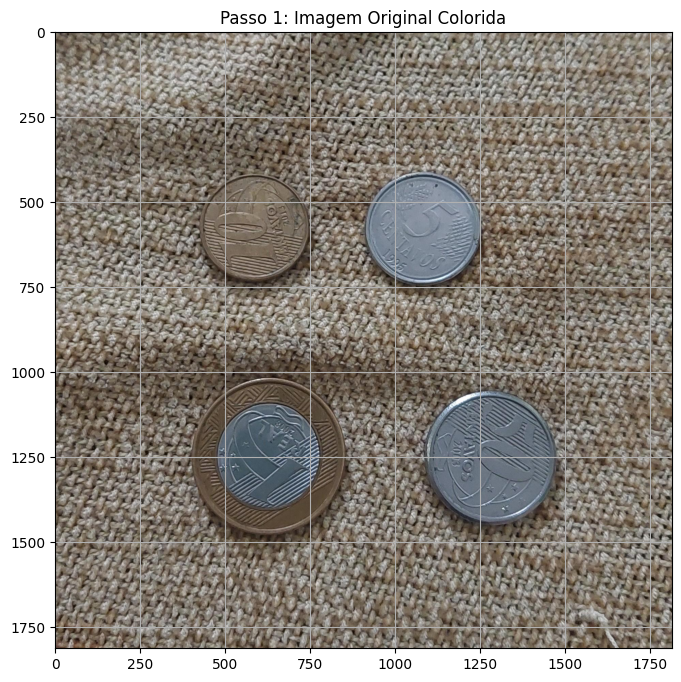

In [1531]:
# --- CARREGAR A IMAGEM ---

caminho_arquivo = '../images/coin_11.jpg'

imagem_original = imread(caminho_arquivo)

plt.figure(figsize=(8, 8))
plt.imshow(imagem_original)
plt.title("Passo 1: Imagem Original Colorida")
plt.grid(True)
plt.show()

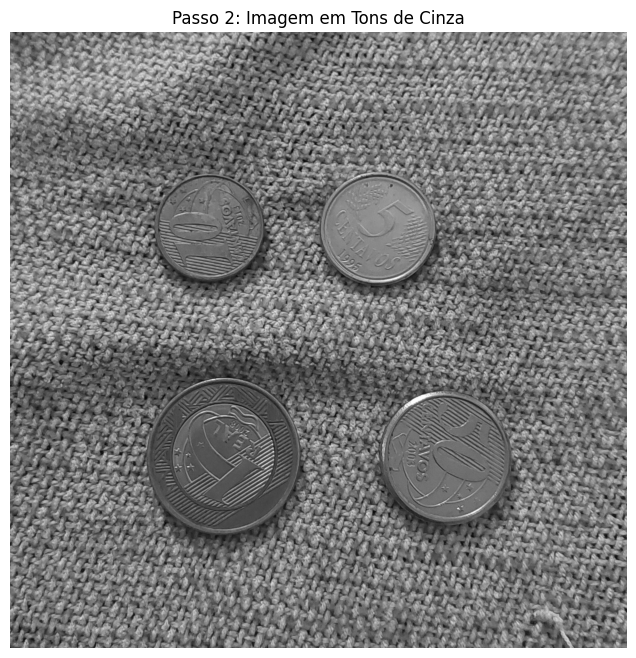

In [1532]:
# --- CONVERSÃO PARA TONS DE CINZA ---

# A função rgb2gray converte a imagem para uma matriz 2D
# O resultado varia de 0.0 (preto absoluto) a 1.0 (branco absoluto)
imagem_cinza = rgb2gray(imagem_original)
imagem_cinza_uint8 = (imagem_cinza * 255).astype(np.uint8)

# Visualizando
plt.figure(figsize=(8, 8))
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Passo 2: Imagem em Tons de Cinza")
plt.axis('off')
plt.show()

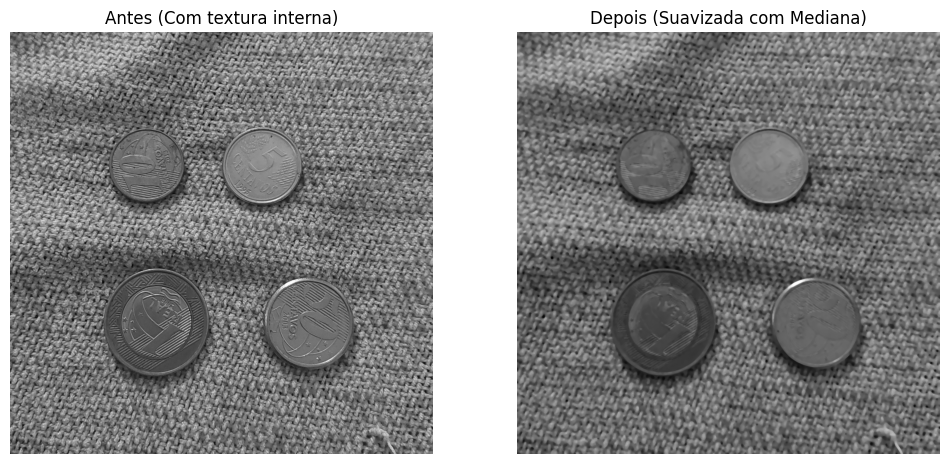

In [1533]:
# --- FILTRAGEM DE RUÍDO (MEDIANA) ---

# Criamos um "elemento estruturante" em forma de disco.
# O número dentro do disk significa o tamanho do raio de um círculo em pixels.
# O filtro vai olhar vizinhanças desse tamanho e pegar o valor do meio (mediana).
elemento_disco = disk(7) 

# Aplicamos o filtro na imagem cinza
imagem_filtrada = median(imagem_cinza_uint8, elemento_disco)

# Visualizando a diferença
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(imagem_cinza_uint8, cmap='gray')
plt.title("Antes (Com textura interna)")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(imagem_filtrada, cmap='gray')
plt.title("Depois (Suavizada com Mediana)")
plt.axis('off')

plt.show()

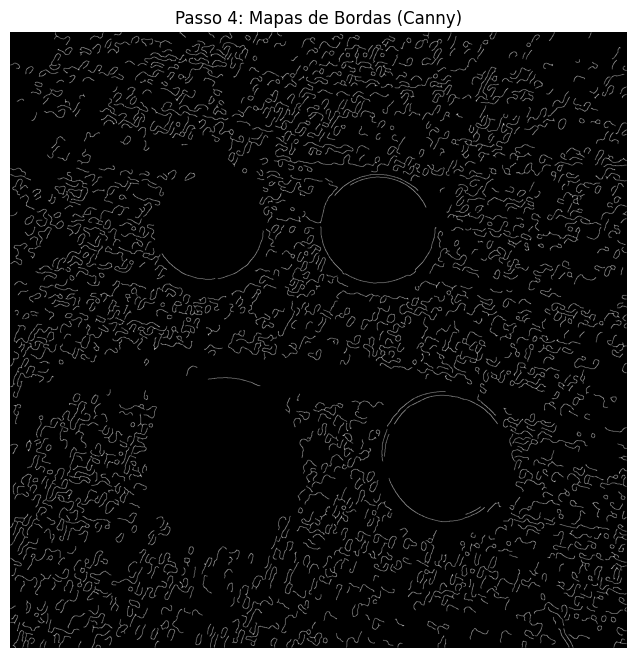

In [1534]:
# --- DETECÇÃO DE BORDAS (CANNY) ---

# O parâmetro 'sigma' controla a suavização.
# sigma=3 é focado em pegar apenas contornos (as moedas).
# Se colocar sigma=1, ele pega qualquer risco.
bordas_canny = canny(imagem_filtrada, sigma=3)

# O resultado é uma imagem binária (True/False): True onde tem borda, False onde é liso.

# Visualizando
plt.figure(figsize=(8, 8))
# Mostramos em fundo preto (gray) onde o branco é a borda
plt.imshow(bordas_canny, cmap='gray') 
plt.title("Passo 4: Mapas de Bordas (Canny)")
plt.axis('off')
plt.show()

In [1535]:
# --- TRANSFORMADA DE HOUGH (CALCULAR CENTROS) ---

# 1. Definir o que estamos procurando
# Aqui dizemos: "Procure círculos que tenham raio mínimo de 40px e máximo de 80px"
# O passo '2' significa que ele tenta 40, 42, 44...
raio_minimo = 30
raio_maximo = 250
passo_raio = 2
intervalo_raios = np.arange(raio_minimo, raio_maximo, passo_raio) 

print("Calculando acumulador de Hough (isso pode demorar um pouco)...")
# Essa função cria o espaço de votos
acumulador_hough = hough_circle(bordas_canny, intervalo_raios)

# 2. Achar os vencedores da votação (Os Picos)
# acumulador_hough: os votos
# intervalo_raios: os raios que testamos
# total_num_peaks: máximo de moedas que esperamos
accums, cx, cy, raios = hough_circle_peaks(acumulador_hough, intervalo_raios,
                                           total_num_peaks=150,
                                           min_xdistance=40, # Distância mínima entre centros (X)
                                           min_ydistance=40, # Distância mínima entre centros (Y)
                                           threshold=0.3 * np.max(acumulador_hough))
# Adicionamos o threshold=0.3 (30% da intensidade máxima encontrada)
# Isso descarta círculos "fracos"
print(f"Detectamos {len(raios)} círculos!")

if len(raios) > 0:
    # 1. Descobrir o tamanho da maior moeda encontrada
    maior_raio_encontrado = np.max(raios)
    
    # 2. Definir o corte (50% do tamanho da maior)
    # Moeda 1 Real = 27mm. Moeda 5 cent = 17mm. Relação = 0.63.
    # Usamos 0.5 (50%) como margem de segurança para erros de perspectiva.
    limite_aceitavel = maior_raio_encontrado * 0.5 

    print(f"Maior raio encontrado: {maior_raio_encontrado:.1f}px")
    print(f"Corte de segurança: Ignorando círculos menores que {limite_aceitavel:.1f}px")

    # 3. Criar uma 'máscara' (filtro)
    # Isso cria uma lista de Verdadeiro/Falso: [True, True, False, True...]
    filtro = raios >= limite_aceitavel

    # 4. Aplicar o filtro em todas as variáveis
    # Só mantém os índices onde o filtro é True
    cx = cx[filtro]
    cy = cy[filtro]
    raios = raios[filtro]
    accums = accums[filtro]

# O print final agora mostrará o número filtrado
print(f"Detectamos {len(raios)} círculos (após filtro de tamanho)!")

Calculando acumulador de Hough (isso pode demorar um pouco)...
Detectamos 150 círculos!
Maior raio encontrado: 164.0px
Corte de segurança: Ignorando círculos menores que 82.0px
Detectamos 2 círculos (após filtro de tamanho)!


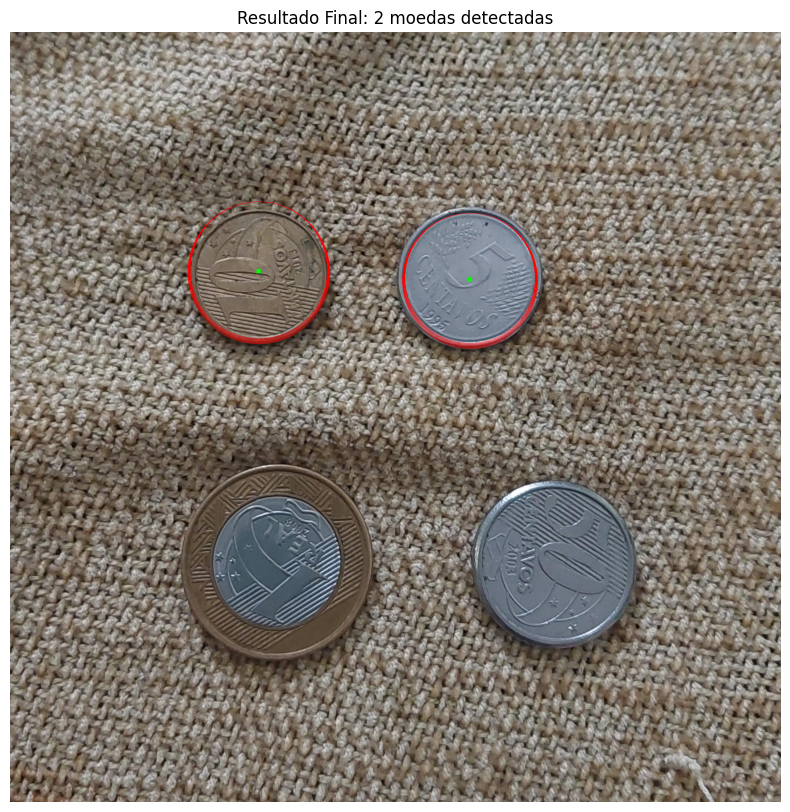

In [1536]:
# --- DESENHANDO O RESULTADO ---

# Cria uma cópia da imagem original para não estragar a variável principal
imagem_resultado = np.copy(imagem_original)

# Loop para desenhar cada moeda encontrada
# zip(cy, cx, raios) junta as listas para processarmos uma moeda por vez
espessura = 3
for centro_y, centro_x, raio in zip(cy, cx, raios):
    for dr in range(-espessura, espessura + 1):
        # circle_perimeter devolve as coordenadas da BORDa do círculo
        circulo_y, circulo_x = circle_perimeter(
            centro_y + dr, centro_x, raio + dr,
            shape=imagem_original.shape
        )
        
        # Pintamos esses pixels de VERMELHO (R=255, G=0, B=0)
        imagem_resultado[circulo_y, circulo_x] = (255, 0, 0)
    
    # Dica extra: Vamos pintar o CENTRO também para ver se ele achou certo
    # Criamos um quadradinho 5x5 no centro
    imagem_resultado[centro_y-5:centro_y+5, centro_x-5:centro_x+5] = (0, 255, 0) # Verde

# Mostra final
plt.figure(figsize=(10, 10))
plt.imshow(imagem_resultado)
plt.title(f"Resultado Final: {len(raios)} moedas detectadas")
plt.axis('off')
plt.show()

In [1537]:
# --- FUNÇÕES E BASE DE DADOS ---

import numpy as np

def extrair_caracteristicas_zonais(img, cx, cy, raio):
    rows, cols = img.shape[:2]
    y, x = np.ogrid[:rows, :cols]
    dist_from_center = np.sqrt((x - cx)**2 + (y - cy)**2)
    
    mask_nucleo = dist_from_center <= (raio * 0.5)
    mask_anel   = (dist_from_center > (raio * 0.6)) & (dist_from_center <= (raio * 0.9))
    
    def get_avg(mask):
        if np.any(mask): return img[mask].mean(axis=0)
        return np.array([0, 0, 0])

    rgb_nucleo = get_avg(mask_nucleo)
    rgb_anel   = get_avg(mask_anel)
    
    # Adicionamos +1 para evitar divisão por zero
    # RB: Red/Blue (Diferencia Prata de Colorida)
    rb_nucleo = rgb_nucleo[0] / (rgb_nucleo[2] + 1)
    rb_anel   = rgb_anel[0]   / (rgb_anel[2] + 1)
    
    # RG: Red/Green (Diferencia Ouro de Cobre)
    # Cobre tem muito vermelho e pouco verde. Ouro tem vermelho e verde parecidos.
    rg_nucleo = rgb_nucleo[0] / (rgb_nucleo[1] + 1)
    
    return rb_nucleo, rg_nucleo, rb_anel

def calcular_probabilidade_gaussiana(valor_medido, valor_ideal, tolerancia):
    erro = abs(valor_medido - valor_ideal)
    return np.exp(- (erro ** 2) / (2 * (tolerancia ** 2)))

# --- BANCO DE DADOS COM PERFIL DE COR EXATO ---
# rb_ideal: Pratas ~ 1.0 | Douradas ~ 1.5 | Cobre ~ 1.6
# rg_ideal: Pratas ~ 1.0 | Douradas ~ 1.1 | Cobre ~ 1.5 (Vermelha)

DB_MOEDAS = {
    # --- MOEDAS ATUAIS ---
    "1 Real": {
        "valor": 1.00, "raio": 1.000, 
        "rb_ideal": 1.0, "rg_ideal": 1.0, # Núcleo Prateado
        "tolerancia_tamanho": 0.08, # Aceita variação normal
        "bimetalica": True
    },
    "50 Centavos": {
        "valor": 0.50, "raio": 0.852, 
        "rb_ideal": 1.05, "rg_ideal": 1.05, # Prata Pura
        "tolerancia_tamanho": 0.03, # <--- RIGOROSO (Para não confundir com 25 antiga)
        "bimetalica": False
    },
    "25 Centavos (Nova)": {
        "valor": 0.25, "raio": 0.926, 
        "rb_ideal": 1.50, "rg_ideal": 1.15, # Dourada (Bronze)
        "tolerancia_tamanho": 0.06,
        "bimetalica": False
    },
    "10 Centavos (Nova)": {
        "valor": 0.10, "raio": 0.741, 
        "rb_ideal": 1.50, "rg_ideal": 1.15, # Dourada (Bronze)
        "tolerancia_tamanho": 0.06,
        "bimetalica": False
    },
    "5 Centavos (Nova)": {
        "valor": 0.05, "raio": 0.815, 
        "rb_ideal": 1.60, "rg_ideal": 1.45, # COBRE (Vermelhão)
        "tolerancia_tamanho": 0.04, # Um pouco mais rigoroso para não bater com 10 antiga
        "bimetalica": False
    },
    
    # --- MOEDAS ANTIGAS (PRATAS CONFUSAS) ---
    # Tolerâncias muito baixas (0.03) para forçar o tamanho exato
    "25 Centavos (Antiga)": {
        "valor": 0.25, "raio": 0.870, 
        "rb_ideal": 1.05, "rg_ideal": 1.05,
        "tolerancia_tamanho": 0.025, # <--- SUPER RIGOROSO
        "bimetalica": False
    },
    "10 Centavos (Antiga)": {
        "valor": 0.10, "raio": 0.815, 
        "rb_ideal": 1.05, "rg_ideal": 1.05,
        "tolerancia_tamanho": 0.03,
        "bimetalica": False
    },
    "5 Centavos (Antiga)": {
        "valor": 0.05, "raio": 0.778, 
        "rb_ideal": 1.05, "rg_ideal": 1.05,
        "tolerancia_tamanho": 0.03,
        "bimetalica": False
    }
}
print("Banco de dados atualizado com tolerâncias dinâmicas e cores probabilísticas.")

Banco de dados atualizado com tolerâncias dinâmicas e cores probabilísticas.


--- RELATÓRIO DE INSPEÇÃO ---

MOEDA 1:
   > Raio: 156px (Relativo: 0.95)
   > Cor R/B (Metal): 0.83
   > Cor R/G (Tom):   0.92
   > Classificação Visual: Prata (Inox)

MOEDA 2:
   > Raio: 164px (Relativo: 1.00)
   > Cor R/B (Metal): 1.27
   > Cor R/G (Tom):   1.11
   > Classificação Visual: Dourado (Bronze)


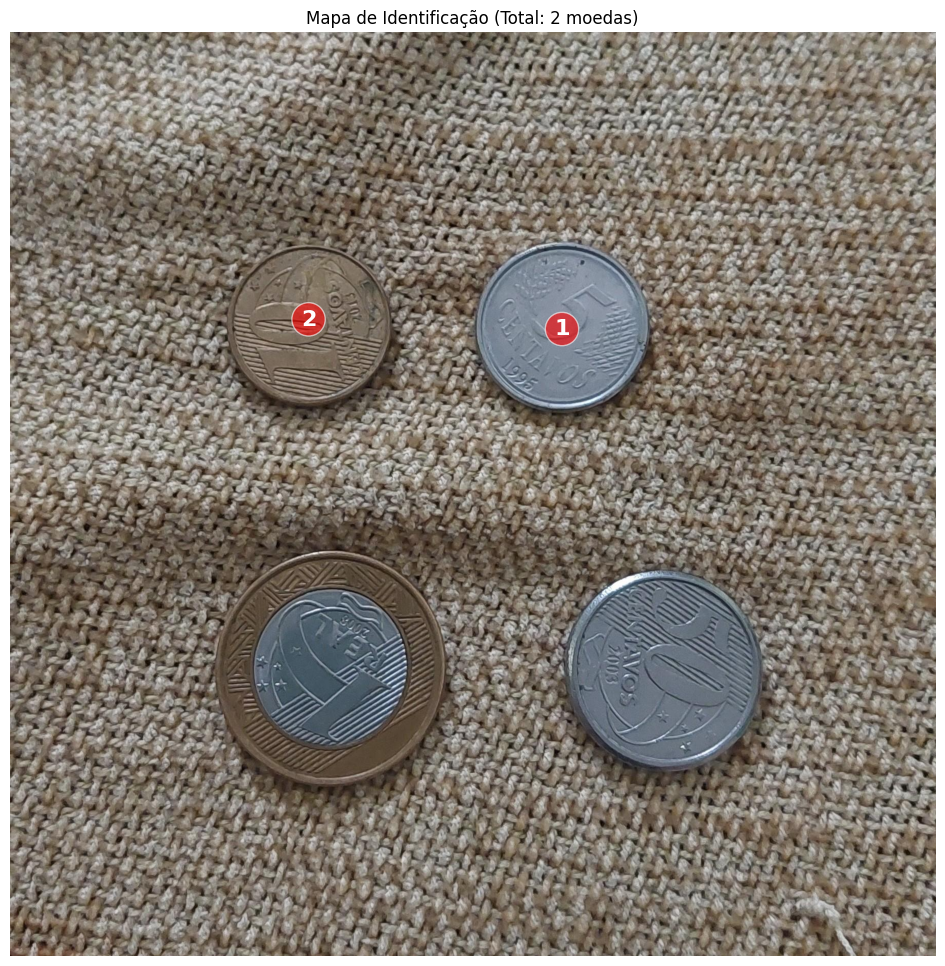

In [1538]:
# --- RELATÓRIO VISUAL DETALHADO (ID + ZONAS + COBRE) ---

print(f"--- RELATÓRIO DE INSPEÇÃO ---")
raio_referencia = np.max(raios) # A maior moeda define a escala 1.0

# Prepara a imagem para desenhar os números
plt.figure(figsize=(12, 12))
plt.imshow(imagem_original)
plt.title(f"Mapa de Identificação (Total: {len(raios)} moedas)")
plt.axis('off')

# Loop de Análise
for i, (centro_y, centro_x, raio) in enumerate(zip(cy, cx, raios)):
    
    id_moeda = i + 1
    
    # rb_nuc: Red/Blue (Diferencia Prata de Colorido)
    # rg_nuc: Red/Green (Diferencia Ouro de Cobre)
    # rb_anel: Red/Blue da borda (Para achar 1 Real)
    rb_nuc, rg_nuc, rb_anel = extrair_caracteristicas_zonais(imagem_original, centro_x, centro_y, raio)
    
    raio_relativo = raio / raio_referencia
    
    # --- Lógica de Visualização do Tipo ---
    tipo_material = "Desconhecido"
    
    if rb_nuc < 1.25:
        tipo_material = "Prata (Inox)"
    elif rg_nuc > 1.15: # Se tem muito vermelho comparado ao verde
        tipo_material = "COBRE (Vermelha)"
    else:
        tipo_material = "Dourado (Bronze)"
        
    # Checagem visual de bimetálica
    if rb_nuc < 1.25 and rb_anel > 1.25:
        tipo_material = "Bimetálica (1 Real)"

    # --- Visualização ---
    plt.text(centro_x, centro_y, str(id_moeda), 
             color='white', fontsize=16, fontweight='bold', 
             ha='center', va='center', 
             bbox=dict(facecolor='red', alpha=0.6, edgecolor='white', boxstyle='circle'))

    # --- IMPRESSÃO DOS DADOS ---
    print(f"\nMOEDA {id_moeda}:")
    print(f"   > Raio: {raio:.0f}px (Relativo: {raio_relativo:.2f})")
    print(f"   > Cor R/B (Metal): {rb_nuc:.2f}")
    print(f"   > Cor R/G (Tom):   {rg_nuc:.2f}")
    print(f"   > Classificação Visual: {tipo_material}")

plt.show()

--- RESULTADO FINANCEIRO (FUZZY + VETO) ---

Moeda 1 (R/B=0.83 | R/G=0.92 | Tam=0.95):
   Status: PRATA/CINZA
   -> 1º: 1 Real (67.7%)
      2º: 25 Centavos (Antiga) (13.5%)

Moeda 2 (R/B=1.27 | R/G=1.11 | Tam=1.00):
   Status: COLORIDA
   -> 1º: 25 Centavos (Nova) (68.1%)
      2º: 10 Centavos (Nova) (44.7%)


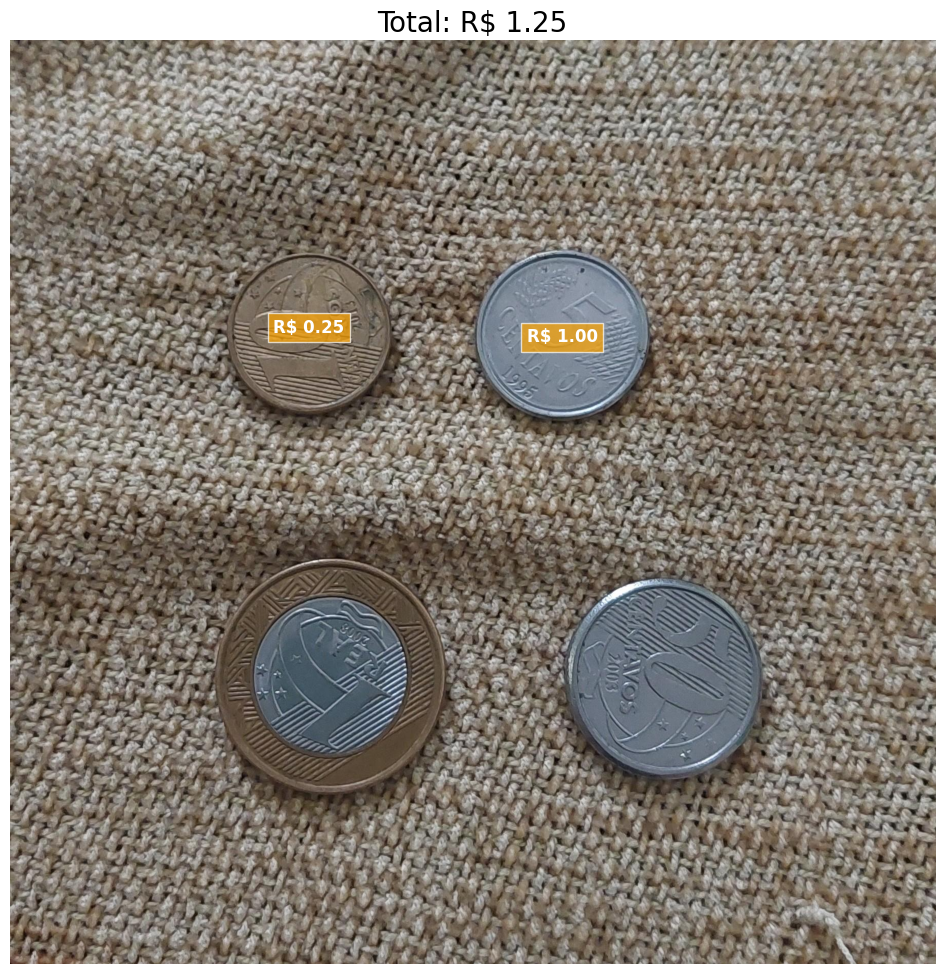


=== SOMA: R$ 1.25 ===


In [1539]:
# --- CÉLULA 10: CLASSIFICAÇÃO PROBABILÍSTICA (CORRIGIDA PARA NOVA BASE DE DADOS) ---

print(f"--- RESULTADO FINANCEIRO (FUZZY + VETO) ---")

total_dinheiro = 0.0
imagem_final = np.copy(imagem_original)

plt.figure(figsize=(12, 12))
plt.imshow(imagem_final)
plt.axis('off')

# Parâmetros
LIMIAR_VETO_COR = 1.20      # O divisor de águas da IMAGEM (Acima=Colorida, Abaixo=Cinza)
LIMIAR_IDEAL_DB = 1.25      # O divisor de águas do BANCO DE DADOS
TOLERANCIA_COR_SCORE = 0.25 # Tolerância para o cálculo da nota de cor

for i, (centro_y, centro_x, raio) in enumerate(zip(cy, cx, raios)):
    
    raio_relativo = raio / raio_referencia
    rb_nuc, rg_nuc, rb_anel = extrair_caracteristicas_zonais(imagem_final, centro_x, centro_y, raio)
    
    # 1. ANÁLISE VISUAL DA IMAGEM
    # A moeda na imagem parece colorida (Cobre/Ouro) ou Cinza (Prata)?
    imagem_parece_colorida = (rb_nuc > LIMIAR_VETO_COR)
    
    # É bimetálica? (Centro Prata e Borda Dourada)
    is_bimetalica = (rb_nuc < 1.20) and (rb_anel > 1.20)
    
    ranking = []
    
    status_visual = "COLORIDA" if imagem_parece_colorida else "PRATA/CINZA"
    print(f"\nMoeda {i+1} (R/B={rb_nuc:.2f} | R/G={rg_nuc:.2f} | Tam={raio_relativo:.2f}):")
    print(f"   Status: {status_visual}")
    
    for nome, db in DB_MOEDAS.items():
        
        # --- PASSO A: VETO RÍGIDO (A GUILHOTINA) ---
        # Descobrir o que o banco de dados ESPERA dessa moeda
        # Se rb_ideal < 1.25, o DB espera uma moeda Prata. Se maior, espera Colorida.
        db_espera_colorida = (db['rb_ideal'] > LIMIAR_IDEAL_DB)
        
        # Se a expectativa não bate com a realidade -> NOTA ZERO.
        if db_espera_colorida != imagem_parece_colorida:
            # Mata a probabilidade de ser essa moeda
            ranking.append((0.0, nome, db['valor'])) 
            continue 

        # --- PASSO B: CÁLCULO DE PROBABILIDADE (Se passou no veto) ---

        # 1. Score de Tamanho (Usando a tolerância específica de cada moeda)
        score_tamanho = calcular_probabilidade_gaussiana(raio_relativo, db['raio'], db['tolerancia_tamanho'])
        
        # 2. Score de Cor (Quão perfeita é a cor?)
        prob_rb = calcular_probabilidade_gaussiana(rb_nuc, db['rb_ideal'], TOLERANCIA_COR_SCORE)
        prob_rg = calcular_probabilidade_gaussiana(rg_nuc, db['rg_ideal'], TOLERANCIA_COR_SCORE)
        score_cor = (prob_rb + prob_rg) / 2.0
        
        # 3. Score de Estrutura (Bimetálica)
        if db['bimetalica']: 
            score_est = 1.0 if is_bimetalica else 0.0
        else:
            score_est = 0.0 if is_bimetalica else 1.0
            
        # Média Final Ponderada
        score_final = (score_tamanho * 0.5) + (score_cor * 0.3) + (score_est * 0.2)
        
        # Penalidade Extra para Pratas Confusas
        # Se é supostamente prata, mas o tamanho não está EXATO, penaliza.
        # Isso ajuda a separar 50 centavos de 25 antiga.
        if not db_espera_colorida and score_tamanho < 0.7:
             score_final -= 0.3
             
        # Bonus para 1 Real se for bimetálica
        if nome == "1 Real" and is_bimetalica:
            score_final += 0.5

        ranking.append((score_final, nome, db['valor']))
    
    # --- RESULTADO FINAL DA MOEDA ---
    ranking.sort(key=lambda x: x[0], reverse=True)
    
    if len(ranking) > 0:
        top1_score, top1_nome, top1_valor = ranking[0]
        
        # Exige confiança mínima de 10% (já que passamos pelo veto, quem sobrar é lucro)
        if top1_score > 0.1: 
            total_dinheiro += top1_valor
            texto = f"R$ {top1_valor:.2f}"
            
            # Cor da caixa muda conforme a confiança
            if top1_score > 0.8: cor_box = 'green'
            elif top1_score > 0.5: cor_box = 'orange'
            else: cor_box = 'red'
            
            print(f"   -> 1º: {top1_nome} ({top1_score*100:.1f}%)")
            if len(ranking) > 1:
                print(f"      2º: {ranking[1][1]} ({ranking[1][0]*100:.1f}%)")
        else:
            texto = "?"
            cor_box = 'gray'
            print(f"   -> Nenhuma compatível (Veto eliminou todas ou tamanho errado)")
        # Desenhar valor na imagem
        plt.text(centro_x, centro_y, texto, color='white', fontsize=12, fontweight='bold', 
             ha='center', va='center', bbox=dict(facecolor=cor_box, alpha=0.7, edgecolor='white'))

plt.title(f"Total: R$ {total_dinheiro:.2f}", fontsize=20)
plt.show()
print(f"\n=== SOMA: R$ {total_dinheiro:.2f} ===")